In [ ]:
#importing libraries
import zipfile
import os

# Path to the zip file
zip_file_path = "./OriginalDataset.zip"  # path to the zipfile
extract_to_path = "Dataset"  # Directory to extract contents to

# Unzipping the folder
if not os.path.exists(extract_to_path):  
    os.makedirs(extract_to_path)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: #it opens the zipfile to read
        zip_ref.extractall(extract_to_path) #extracts all content of zipfile
        print(f"Extracted {zip_file_path} to {extract_to_path}") #it confirms sucessful extraction
except FileNotFoundError:
    print(f"The file {zip_file_path} was not found.") #it handles the case if zipfile is not found 
except zipfile.BadZipFile:
    print(f"The file {zip_file_path} is not a valid zip file.") #it handles the case if zipfile is not valid


Extracted ./OriginalDataset.zip to Dataset


In [ ]:
#installing tensorflow library
!pip install tensorflow

In [ ]:
#imorting and checking tensorfow version
import tensorflow as tf
print(tf.__version__)


2024-12-12 08:58:35.559960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 08:58:36.605039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 08:58:36.909569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 08:58:39.254041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 08:58:45.008544: W tensorflow/compiler/tf2

2.17.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt

# Loading dataset
data_dir = "./Dataset/OriginalDataset"  # path to extracted directory
img_height, img_width = 128, 128 #dimensions
batch_size = 64 #number of images per batch for training

#creates a dataset and normalizes images to range [-1, 1]
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode=None, #ignores labes and focus on images
    image_size=(img_height, img_width),
    batch_size=batch_size #groups image to batches
).map(lambda x: (x - 127.5) / 127.5)  # Normalize images to [-1, 1]

# Defining the Generator model with Debugging

# A fully connected layer that projects input noise into 3D space
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) #it stabilizes training
    model.add(layers.LeakyReLU()) # adds non-linearity
    print("After Dense layer:", model.output_shape)

    #reshape into 3D tensor
    model.add(layers.Reshape((8, 8, 256)))
    print("After Reshape layer:", model.output_shape)
    assert model.output_shape == (None, 8, 8, 256)

    # To improve the image, convolutional layers will be transposed.
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print("After Conv2DTranspose 1:", model.output_shape)

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print("After Conv2DTranspose 2:", model.output_shape)

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print("After Conv2DTranspose 3:", model.output_shape)

    # An extra layer for additional upsampling
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print("After Conv2DTranspose 4:", model.output_shape)

    # The last output layer that uses tanh activation to create an RGB image
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    print("After Conv2DTranspose 5 (Final):", model.output_shape)

    assert model.output_shape == (None, 128, 128, 3)

    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Using convolutional layers to downsize the image's size
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and produce a single score (fake or real).
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Describe optimizers and loss functions.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#creats models
generator = make_generator_model()
discriminator = make_discriminator_model()

# optimizers for both models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training the DCGAN parameters
EPOCHS = 100
noise_dim = 100 #dimensions of noise input
num_examples_to_generate =  16 #number of images to generate

#fixed seed
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim]) # generates random noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        #generates fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #outputs for real or fake images
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    #computees gradients and updates weights
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training function of the model
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # saves images
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Epoch {epoch+1} completed')

# function to save generated images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    categories = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
    base_dir = "GeneratedDataset4"
    for category in categories:
        os.makedirs(os.path.join(base_dir, category), exist_ok=True) # makes sure the directory exists

    for i in range(predictions.shape[0]):
        category = categories[i % len(categories)]  # Assign categories in a round-robin fashion
        output_dir = os.path.join(base_dir, category)
        plt.imshow((predictions[i] + 1) / 2)  # Rescale [-1, 1] to [0, 1]
        plt.axis('off')
        plt.savefig(os.path.join(output_dir, f'image_epoch_{epoch:04d}_img_{i}.png')) #saves images
        plt.close()

# Start training the GAN
train(train_ds, EPOCHS)

Found 6400 files.
After Dense layer: (None, 16384)
After Reshape layer: (None, 8, 8, 256)
After Conv2DTranspose 1: (None, 16, 16, 128)
After Conv2DTranspose 2: (None, 32, 32, 64)
After Conv2DTranspose 3: (None, 64, 64, 32)
After Conv2DTranspose 4: (None, 128, 128, 16)
After Conv2DTranspose 5 (Final): (None, 128, 128, 3)
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epo

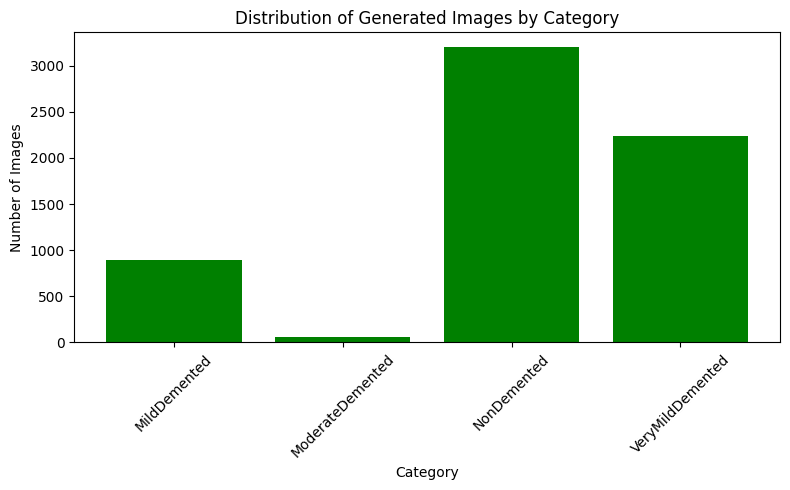

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of images in each category
generated_dir = "./Dataset/OriginalDataset" #path to the dataset
categories = os.listdir(generated_dir) # listv all sub directories
category_counts = {category: len(os.listdir(os.path.join(generated_dir, category))) for category in categories} #counts total images in all sub directories

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='green')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Generated Images by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

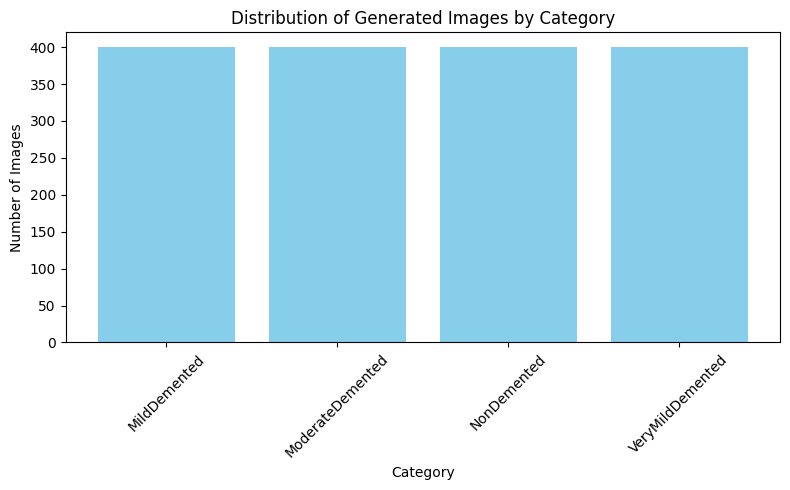

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of images in each category
generated_dir = "GeneratedDataset4" #path to the generated dataset
categories = os.listdir(generated_dir) # lists all generated sub directories
category_counts = {category: len(os.listdir(os.path.join(generated_dir, category))) for category in categories} #counts total images generated in all sub directories

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Generated Images by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


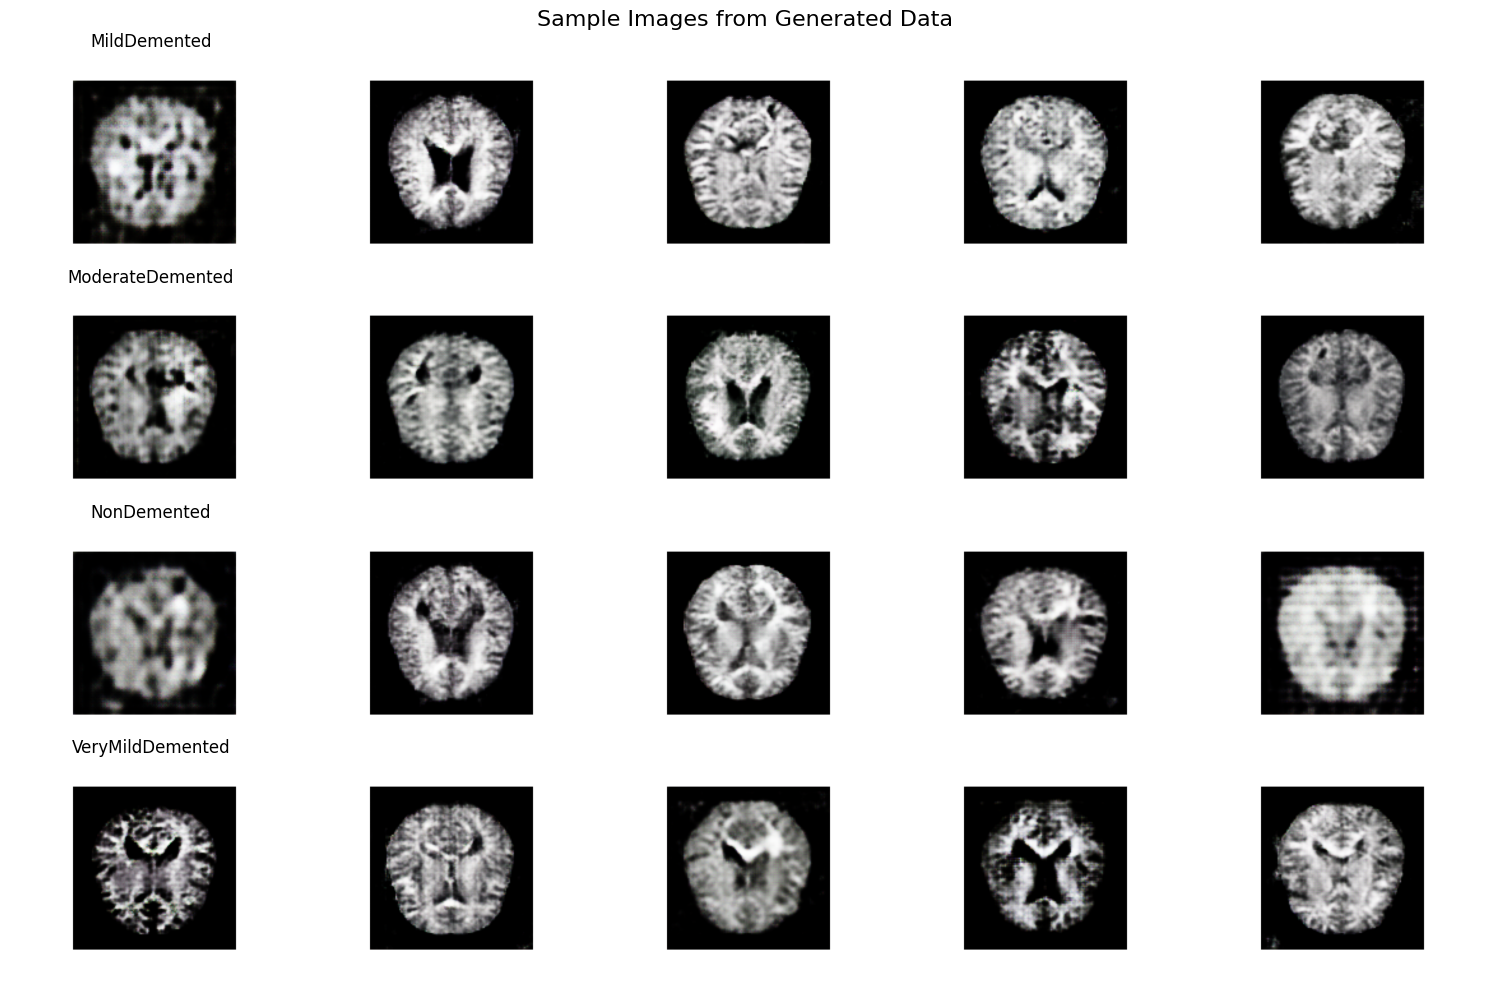

In [ ]:
import random
from PIL import Image #library to open and process image files

# Display sample images from each category
fig, axes = plt.subplots(len(categories), 5, figsize=(15, 10))
for i, category in enumerate(categories):
    category_path = os.path.join(generated_dir, category) #path to the directory
    sample_images = random.sample(os.listdir(category_path), 5) #randomly selects 5 images

    for j, image_file in enumerate(sample_images): # go over the five chosen photos again.
        img_path = os.path.join(category_path, image_file) #full path to image
        img = Image.open(img_path)#opens imageb using PIL
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0: # Make the first column of each row's title the category name.
            axes[i, j].set_title(category)

#adds titles
plt.suptitle('Sample Images from Generated Data', fontsize=16)
#adjusts layout so images dont overlap
plt.tight_layout()
#shows the grid in images
plt.show()


In [ ]:
import shutil # for file and directory operations

# Path to the folder to be zipped
folder_to_zip = "GeneratedDataset4"

# Create a zip file
shutil.make_archive("GeneratedDataset4", "zip", folder_to_zip)

print("Folder zipped successfully!")

Folder zipped successfully!


In [ ]:
#install scikit-learn using conda
!conda install -y scikit-learn

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: - \ done

## Package Plan ##

  environment location: /anaconda

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |         openblas          46 KB
    ca-certificates-2024.11.26 |       h06a4308_0         131 KB
    certifi-2024.8.30          |  py312h06a4308_0         163 KB
    conda-24.11.1              |  py312h06a4308_0         1.2 MB
    joblib-1.4.2               |  py312h06a4308_0         513 KB
    libgfortran-ng-11.2.0      |       h00389a5_1          20 KB
    libgfortran5-11.2.0        |       h1234567_1         2.0 MB
    libopenblas-0.3.21         |       h043d6bf_0         5.4 MB
    numpy-1.26.4               |  py312h2809609_0          10 KB
    numpy-base-1.26.4          |  py312he1a6c75_0         7.7 MB
    scikit-lea

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf

# Define paths
generated_base_dir = "./GeneratedDataset4" #path to generated dataset
split_base_dir = "./SplitDataset4" #path to save split data

# Create directories for split data
train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "validation")
test_dir = os.path.join(split_base_dir, "test")

# Create folders for train, validation, and test sets along with subcategories
for folder in ["train", "validation", "test"]:
    os.makedirs(os.path.join(split_base_dir, folder), exist_ok=True)
    for category in ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]:
        os.makedirs(os.path.join(split_base_dir, folder, category), exist_ok=True)

# Split the generated dataset
categories = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
split_ratios = [0.7, 0.15, 0.15]  # Train: 70%, Validation: 15%, Test: 15%

for category in categories:
    category_path = os.path.join(generated_base_dir, category)
    images = os.listdir(category_path)

    # Split into train, validation, and test sets
    train_images, test_images = train_test_split(images, test_size=split_ratios[2], random_state=42)
    train_images, val_images = train_test_split(train_images, test_size=split_ratios[1] / (1 - split_ratios[2]), random_state=42)

    # Move images to respective directories
    for image in train_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category))
    for image in val_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(val_dir, category))
    for image in test_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category))

print("Generated data successfully split into train, validation, and test folders.")

# preprocessing the split data for model training
img_height, img_width = 128, 128
batch_size = 64

#function to preprocess 
def preprocess_split_data(base_dir, subset):
    dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_dir, subset),
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int'  # Use integer labels for classification
    ).map(lambda x, y: ((x - 127.5) / 127.5, y))  # Normalize images to [-1, 1]

    return dataset

# Preprocess train, validation, and test datasets
train_ds = preprocess_split_data(split_base_dir, "train")
val_ds = preprocess_split_data(split_base_dir, "validation")
test_ds = preprocess_split_data(split_base_dir, "test")

# Inspect dataset shapes
print(f"Train Dataset: {train_ds}")
print(f"Validation Dataset: {val_ds}")
print(f"Test Dataset: {test_ds}")


2024-12-12 18:15:03.010031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 18:15:04.199502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 18:15:04.523304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 18:15:07.093729: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 18:15:12.672394: W tensorflow/compiler/tf2

Generated data successfully split into train, validation, and test folders.
Found 1116 files belonging to 4 classes.
Found 240 files belonging to 4 classes.
Train Dataset: <_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation Dataset: <_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test Dataset: <_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Found 1116 files belonging to 4 classes.
Found 244 files belonging to 4 classes.
Found 240 files belonging to 4 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.2446 - loss: 1.8249 - val_accuracy: 0.2500 - val_loss: 1.3845
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step - accuracy: 0.2683 - loss: 1.3842 - val_accuracy: 0.2500 - val_loss: 1.3807
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step - accuracy: 0.2757 - loss: 1.3812 - val_accuracy: 0.4672 - val_loss: 1.3712
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - accuracy: 0.3063 - loss: 1.3636 - val_accuracy: 0.3730 - val_loss: 1.3328
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.3841 - loss: 1.3125 - val_accuracy: 0.5574 - val_loss: 1.2045
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - accuracy: 0.4928 - loss: 1.1481 

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-12 20:04:01.070860: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


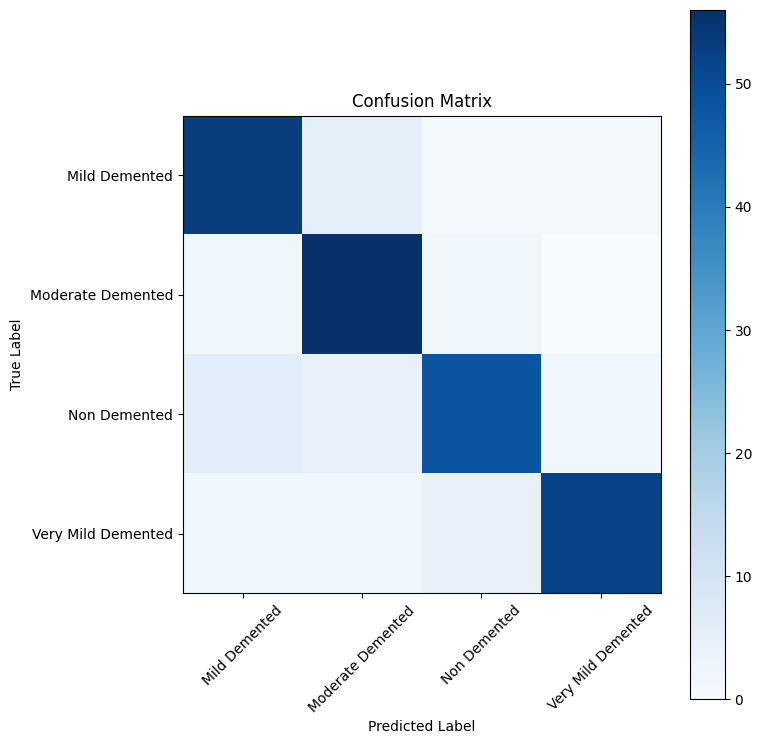

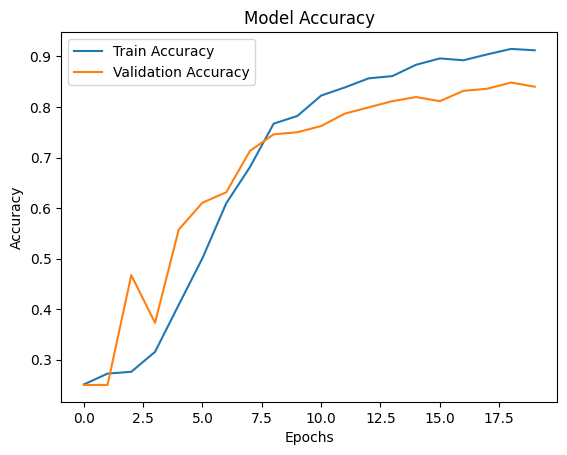

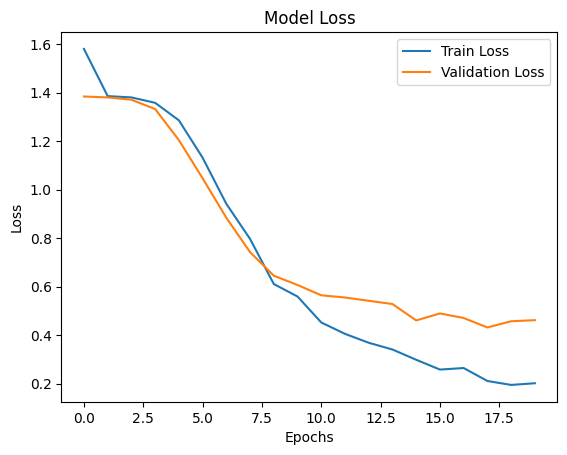

Model saved as 'cnn_classification_model.h5'
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Labels: ['Mild Demented', 'Very Mild Demented', 'Very Mild Demented', 'Moderate Demented', 'Moderate Demented', 'Mild Demented', 'Non Demented', 'Very Mild Demented', 'Non Demented', 'Very Mild Demented', 'Moderate Demented', 'Moderate Demented', 'Non Demented', 'Non Demented', 'Moderate Demented', 'Non Demented', 'Mild Demented', 'Moderate Demented', 'Mild Demented', 'Moderate Demented', 'Very Mild Demented', 'Very Mild Demented', 'Mild Demented', 'Non Demented', 'Non Demented', 'Non Demented', 'Mild Demented', 'Moderate Demented', 'Moderate Demented', 'Very Mild Demented', 'Moderate Demented', 'Very Mild Demented', 'Mild Demented', 'Non Demented', 'Very Mild Demented', 'Very Mild Demented', 'Very Mild Demented', 'Very Mild Demented', 'Mild Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented', 'Moderate Demented', 'Mild Demented', 'Very Mil

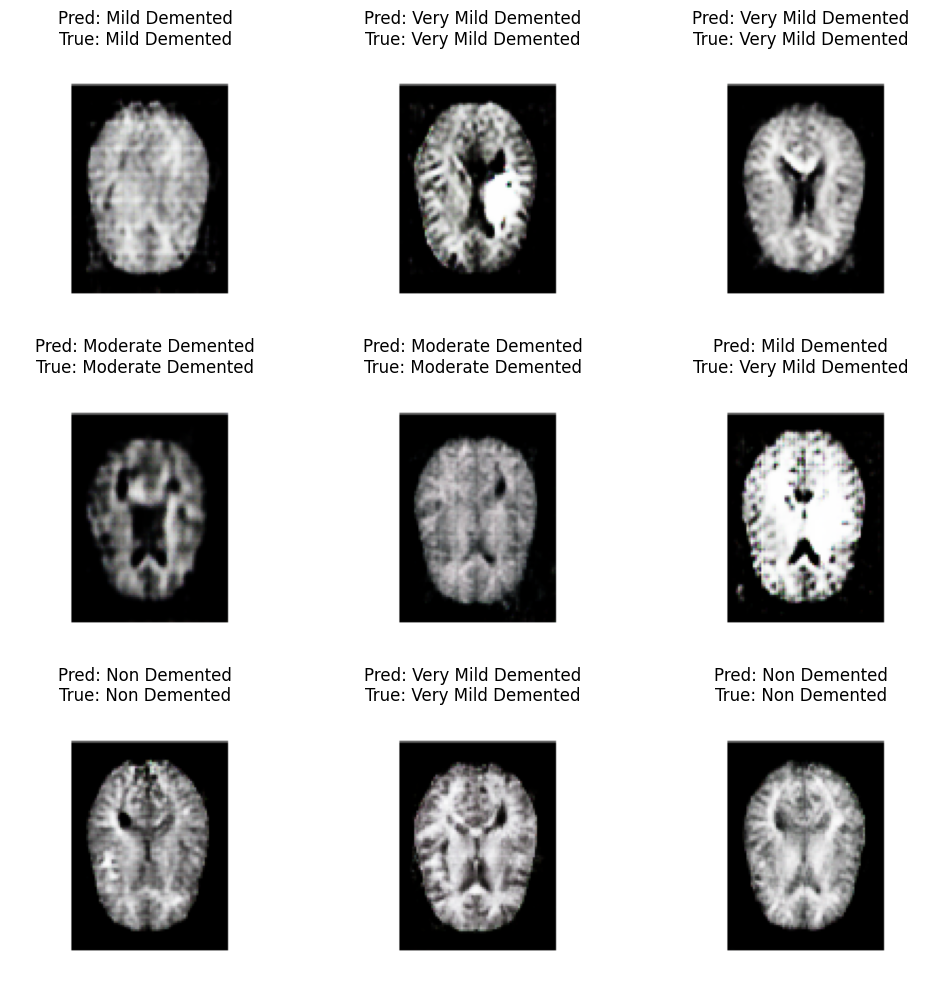

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

#Preprocessing the Split Dataset
img_height, img_width = 128, 128
batch_size = 64

#preprocess function, loads images, resizes, normalizes pixel sizes
def preprocess_split_data(base_dir, subset):
    dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_dir, subset),
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int'  # Use integer labels for classification
    ).map(lambda x, y: ((x - 127.5) / 127.5, y))  # Normalize images to [-1, 1]

    return dataset

# Paths to split datasets
split_base_dir = "./SplitDataset4"
train_ds = preprocess_split_data(split_base_dir, "train")
val_ds = preprocess_split_data(split_base_dir, "validation")
test_ds = preprocess_split_data(split_base_dir, "test")

#Build the CNN Model
def build_model(input_shape=(128, 128, 3), num_classes=4):
    model = Sequential([
        # Convolutional layers with ReLU activation and MaxPooling
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Flattens the 3D output into 1D and adding dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
    ])
    return model

# Compile the model
model = build_model(input_shape=(128, 128, 3), num_classes=4)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), #adam optimizer
              loss='sparse_categorical_crossentropy', #loss fucntion for multi-class classification
              metrics=['accuracy']) #evaluates accuracy

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save Metrics 
metrics = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "history_accuracy": history.history['accuracy'],
    "history_val_accuracy": history.history['val_accuracy'],
    "history_loss": history.history['loss'], #training loss over epochs
    "history_val_loss": history.history['val_loss'] #validation loss over epochs
}

# Save metrics to a file
import json
with open('cnn_metrics.json', 'w') as f:
    json.dump(metrics, f)
print("Metrics saved to 'cnn_metrics.json'")

# Additional Evaluation Metrics 
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
class_names = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save confusion matrix
np.save('confusion_matrix_cnn.npy', conf_matrix)

# Visualize Training Results 
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Save the Model
model.save('cnn_classification_model.h5')
print("Model saved as 'cnn_classification_model.h5'")

# Make Predictions
# Predict on a batch of test data
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_indices = np.argmax(predictions, axis=1)
    predicted_labels = [class_names[idx] for idx in predicted_indices]
    true_labels = [class_names[idx] for idx in labels.numpy()]

    print(f"Predicted Labels: {predicted_labels}")
    print(f"True Labels: {true_labels}")

    # Display a few images with predictions
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display up to 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 127.5 + 127.5).astype("uint8"))  # Rescale back to [0, 255]
        plt.title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
#summarize the model 
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,158 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Found 1116 files belonging to 4 classes.
Found 244 files belonging to 4 classes.
Found 240 files belonging to 4 classes.
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 907ms/step - accuracy: 0.2699 - loss: 1.5502 - val_accuracy: 0.3115 - val_loss: 1.3481
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 804ms/step - accuracy: 0.2854 - loss: 1.3754 - val_accuracy: 0.3525 - val_loss: 1.3384
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 817ms/step - accuracy: 0.3683 - loss: 1.3358 - val_accuracy: 0.4016 - val_loss: 1.3077
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 813ms/step - accuracy: 0.4044 - loss: 1.3038 - val_accuracy: 0.4057 - val_loss: 1.2948
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 810ms/step - accuracy: 0.4403 - loss: 1.2746 - val_accuracy: 0.4098 - val_loss: 1.2840
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 799ms/step - accuracy: 0.41

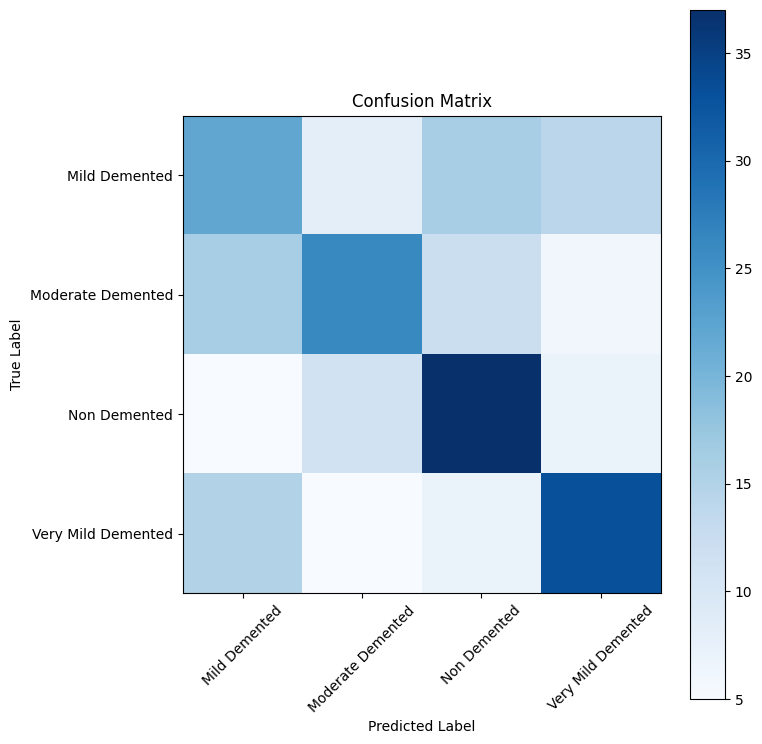

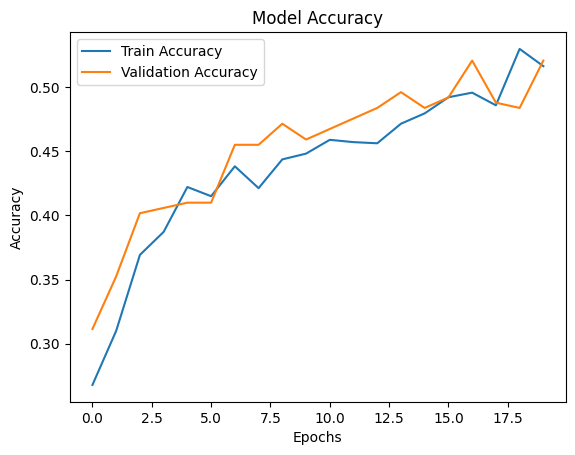

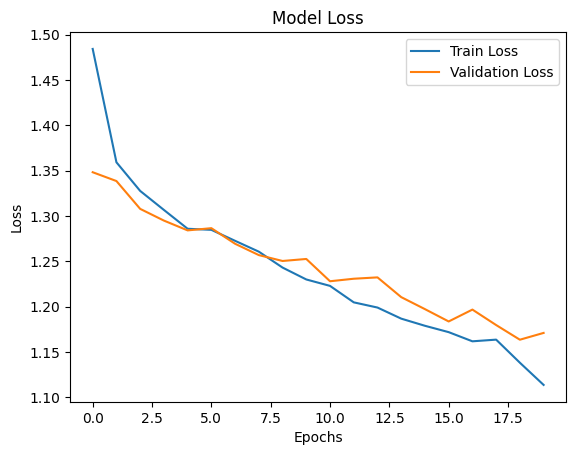

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Preprocessing the Split Dataset
img_height, img_width = 128, 128
batch_size = 64

def preprocess_split_data(base_dir, subset):
    dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_dir, subset),
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int'  # Use integer labels for classification
    ).map(lambda x, y: ((x - 127.5) / 127.5, y))  # Normalize images to [-1, 1]

    return dataset

# Paths to split datasets
split_base_dir = "./SplitDataset4"
train_ds = preprocess_split_data(split_base_dir, "train")
val_ds = preprocess_split_data(split_base_dir, "validation")
test_ds = preprocess_split_data(split_base_dir, "test")

# Build the ResNet50 Model 
def build_resnet_model(input_shape=(128, 128, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Compile the model
model = build_resnet_model(input_shape=(128, 128, 3), num_classes=4)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

# Fine-tune the model
base_model = model.layers[0]  # Access the base ResNet50 model
base_model.trainable = True  # Unfreeze the base model

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#Save Metrics
metrics = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "history_accuracy": history.history['accuracy'],
    "history_val_accuracy": history.history['val_accuracy'],
    "history_loss": history.history['loss'],
    "history_val_loss": history.history['val_loss']
}

# Save metrics to a file
import json
with open('resnet_metrics.json', 'w') as f:
    json.dump(metrics, f)
print("Metrics saved to 'resnet_metrics.json'")

# Additional Evaluation Metrics
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
class_names = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save confusion matrix
np.save('confusion_matrix_resnet.npy', conf_matrix)

#Visualize Training Results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


Found 1116 files belonging to 4 classes.
Found 244 files belonging to 4 classes.
Found 240 files belonging to 4 classes.
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2979 - loss: 2.0259 - val_accuracy: 0.4016 - val_loss: 1.2485
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 832ms/step - accuracy: 0.3516 - loss: 1.3748 - val_accuracy: 0.4467 - val_loss: 1.2500
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 841ms/step - accuracy: 0.3996 - loss: 1.2792 - val_accuracy: 0.4303 - val_loss: 1.2261
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 872ms/step - accuracy: 0.4237 - loss: 1.2625 - val_accuracy: 0.4918 - val_loss: 1.1850
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 833ms/step - accuracy: 0.4135 - loss: 1.1865 - val_accuracy: 0.5041 - val_loss: 1.1674
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 840ms/step - accuracy: 0.50

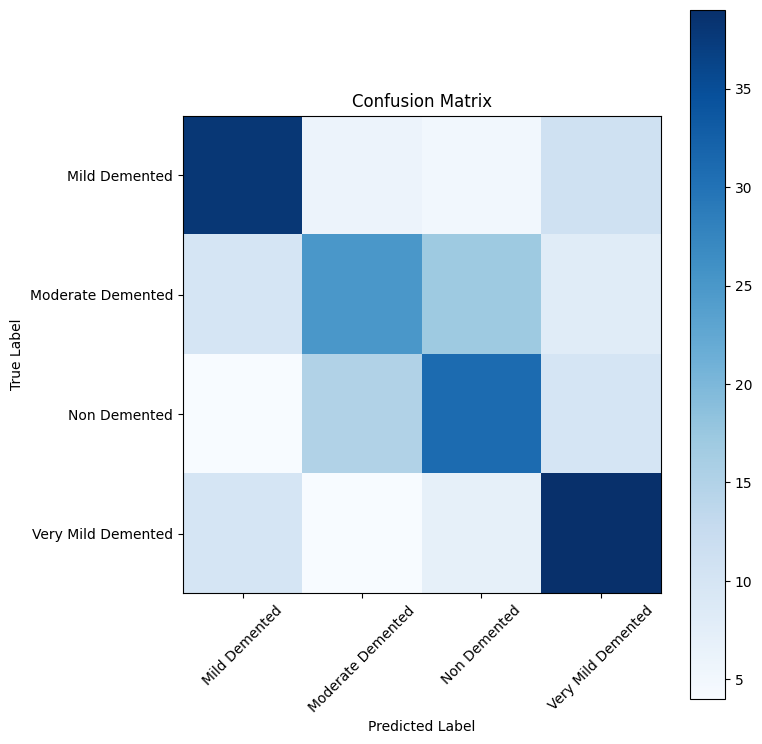

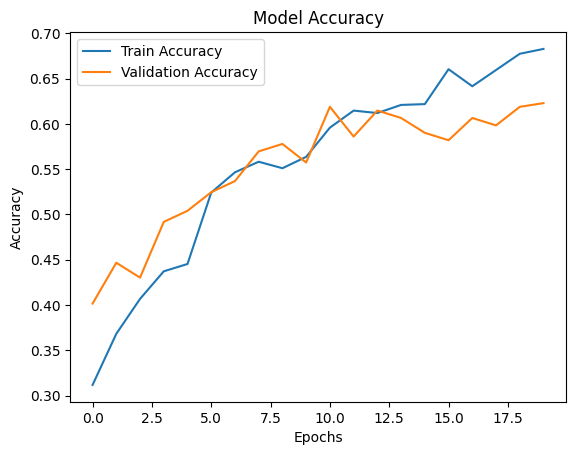

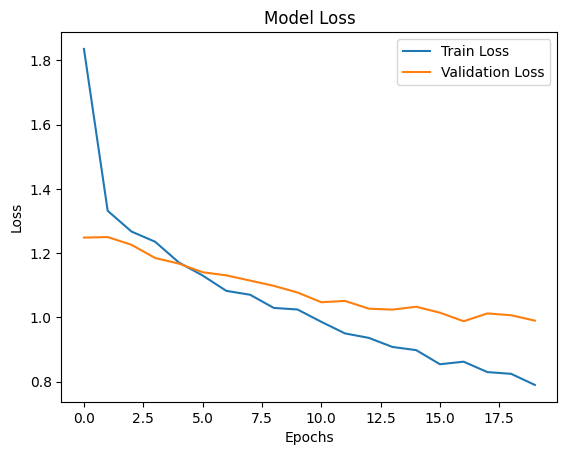

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Preprocessing the Split Dataset 
img_height, img_width = 128, 128
batch_size = 64

def preprocess_split_data(base_dir, subset):
    dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_dir, subset),
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int'  # Use integer labels for classification
    ).map(lambda x, y: ((x - 127.5) / 127.5, y))  # Normalize images to [-1, 1]

    return dataset

# Paths to split datasets
split_base_dir = "./SplitDataset4"
train_ds = preprocess_split_data(split_base_dir, "train")
val_ds = preprocess_split_data(split_base_dir, "validation")
test_ds = preprocess_split_data(split_base_dir, "test")

#Build the DenseNet121 Model
def build_densenet_model(input_shape=(128, 128, 3), num_classes=4):
    # Load the pre-trained DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Add dropout for regularization
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Compile the model
model = build_densenet_model(input_shape=(128, 128, 3), num_classes=4)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

# Fine-tune the model
base_model = model.layers[0]  # Access the base DenseNet121 model
base_model.trainable = True  # Unfreeze the base model

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save Metrics
metrics = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "history_accuracy": history.history['accuracy'],
    "history_val_accuracy": history.history['val_accuracy'],
    "history_loss": history.history['loss'],
    "history_val_loss": history.history['val_loss']
}

# Save metrics to a file
import json
with open('densenet_metrics.json', 'w') as f:
    json.dump(metrics, f)
print("Metrics saved to 'densenet_metrics.json'")

# Additional Evaluation Metrics 
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
class_names = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save confusion matrix
np.save('confusion_matrix_densenet.npy', conf_matrix)

# Visualize Training Results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


Found 1116 files belonging to 4 classes.
Found 244 files belonging to 4 classes.
Found 240 files belonging to 4 classes.
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.2928 - loss: 2.2557 - val_accuracy: 0.3770 - val_loss: 1.3302
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 484ms/step - accuracy: 0.3221 - loss: 1.3546 - val_accuracy: 0.3893 - val_loss: 1.3137
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step - accuracy: 0.3475 - loss: 1.3348 - val_accuracy: 0.4426 - val_loss: 1.2484
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step - accuracy: 0.4040 - loss: 1.2931 - val_accuracy: 0.4959 - val_loss: 1.1967
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - accuracy: 0.4315 - loss: 1.2371 - val_accuracy: 0.5041 - val_loss: 1.1819
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.4681 

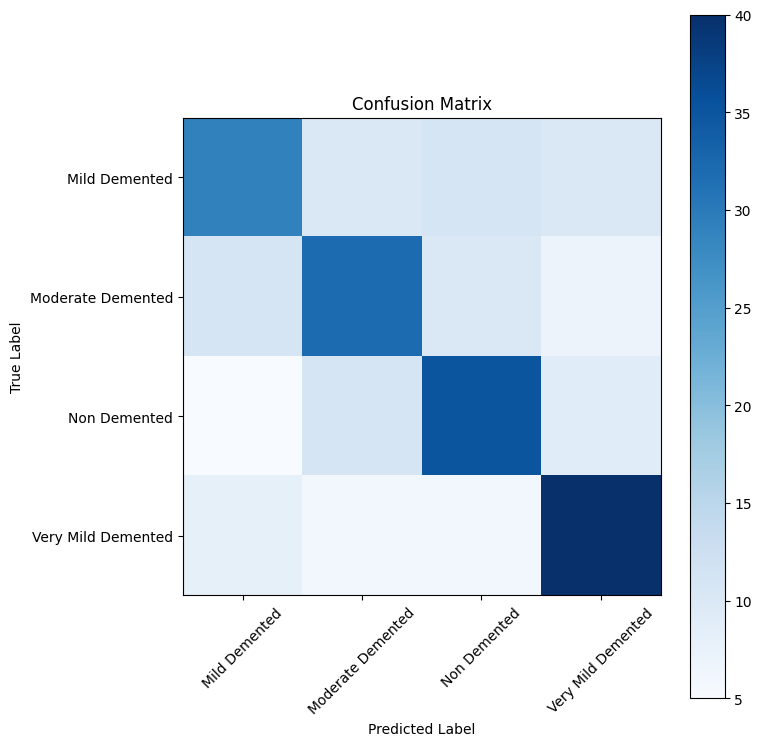

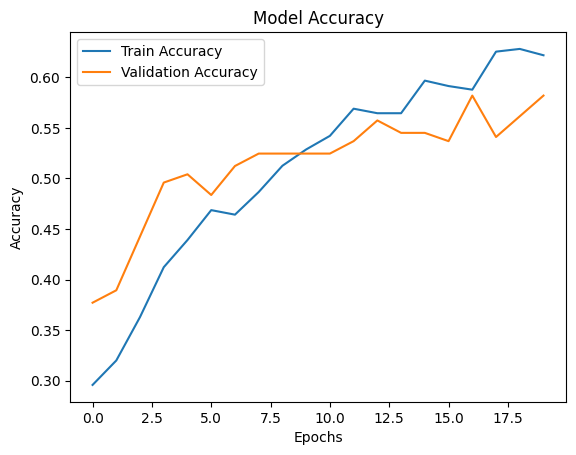

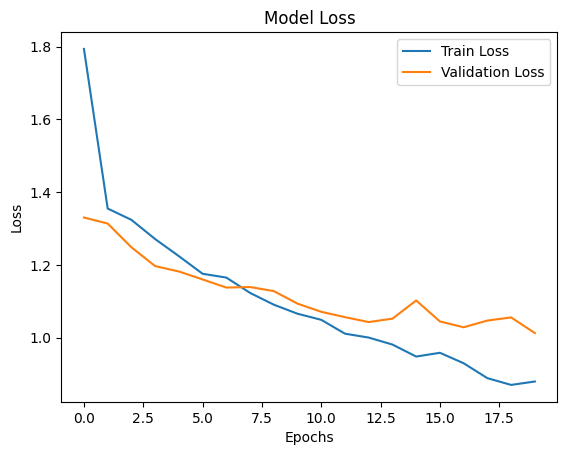

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

#Preprocessing the Split Dataset
img_height, img_width = 128, 128
batch_size = 64

def preprocess_split_data(base_dir, subset):
    dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_dir, subset),
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int'  # Use integer labels for classification
    ).map(lambda x, y: ((x - 127.5) / 127.5, y))  # Normalize images to [-1, 1]

    return dataset

# Paths to split datasets
split_base_dir = "./SplitDataset4"
train_ds = preprocess_split_data(split_base_dir, "train")
val_ds = preprocess_split_data(split_base_dir, "validation")
test_ds = preprocess_split_data(split_base_dir, "test")

#Build the InceptionV3 Model 
def build_inception_model(input_shape=(128, 128, 3), num_classes=4):
    # Load the pre-trained InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Add dropout for regularization
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Compile the model
model = build_inception_model(input_shape=(128, 128, 3), num_classes=4)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

# Fine-tune the model
base_model = model.layers[0]  # Access the base InceptionV3 model
base_model.trainable = True  # Unfreeze the base model

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save Metrics 
metrics = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "history_accuracy": history.history['accuracy'],
    "history_val_accuracy": history.history['val_accuracy'],
    "history_loss": history.history['loss'],
    "history_val_loss": history.history['val_loss']
}

# Save metrics to a file
import json
with open('inceptionv3_metrics.json', 'w') as f:
    json.dump(metrics, f)
print("Metrics saved to 'inceptionv3_metrics.json'")

# Additional Evaluation Metrics 
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
class_names = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save confusion matrix
np.save('confusion_matrix_inceptionv3.npy', conf_matrix)

# Visualize Training Results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


Found 1116 files belonging to 4 classes.
Found 244 files belonging to 4 classes.
Found 240 files belonging to 4 classes.
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 568ms/step - accuracy: 0.2200 - loss: 1.4327 - val_accuracy: 0.2500 - val_loss: 1.3903
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.2580 - loss: 1.3904 - val_accuracy: 0.2500 - val_loss: 1.3912
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.2277 - loss: 1.3983 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.2680 - loss: 1.3872 - val_accuracy: 0.2664 - val_loss: 1.3861
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 450ms/step - accuracy: 0.2385 - loss: 1.3870 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.2644 

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

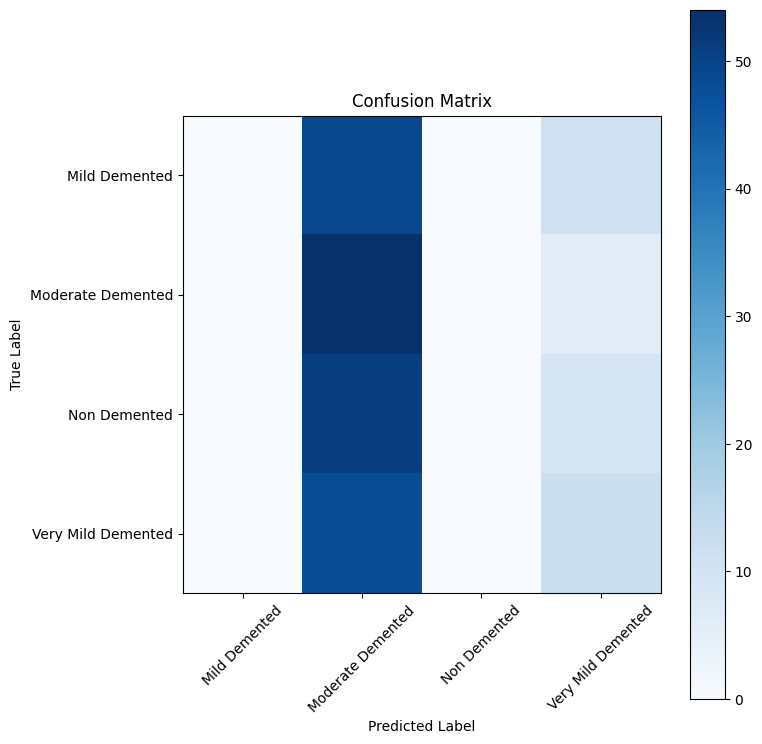

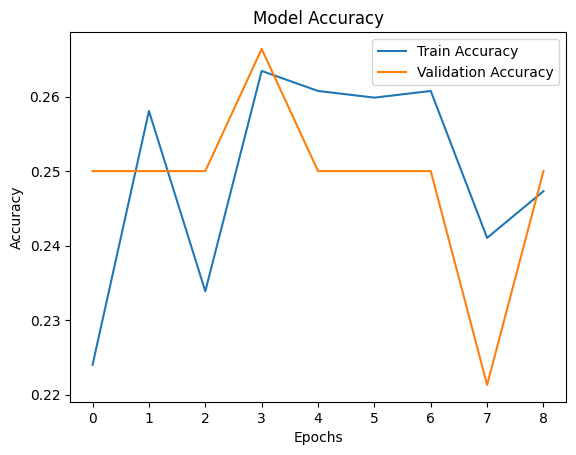

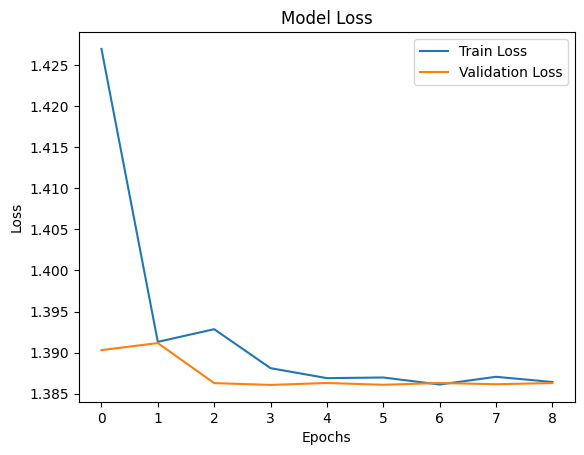

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Preprocessing the Split Dataset 
img_height, img_width = 128, 128
batch_size = 64

def preprocess_split_data(base_dir, subset):
    dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_dir, subset),
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int'  # Use integer labels for classification
    ).map(lambda x, y: ((x - 127.5) / 127.5, y))  # Normalize images to [-1, 1]

    return dataset

# Paths to split datasets
split_base_dir = "./SplitDataset4"
train_ds = preprocess_split_data(split_base_dir, "train")
val_ds = preprocess_split_data(split_base_dir, "validation")
test_ds = preprocess_split_data(split_base_dir, "test")

# Build the EfficientNet Model 
def build_efficientnet_model(input_shape=(128, 128, 3), num_classes=4):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model's layers

    # Add custom layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Compile the model
model = build_efficientnet_model(input_shape=(128, 128, 3), num_classes=4)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

# Fine-tune the model
base_model = model.layers[0]
base_model.trainable = True  # Unfreeze the base model

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the Metrics 
metrics = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "history_accuracy": history.history['accuracy'],
    "history_val_accuracy": history.history['val_accuracy'],
    "history_loss": history.history['loss'],
    "history_val_loss": history.history['val_loss']
}

# Save metrics to a file
import json
with open('efficientnet_metrics.json', 'w') as f:
    json.dump(metrics, f)
print("Metrics saved to 'efficientnet_metrics.json'")

# Additional Evaluation Metrics 
# Generate predictions
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save confusion matrix
np.save('confusion_matrix.npy', conf_matrix)

# Visualize Training Results 
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


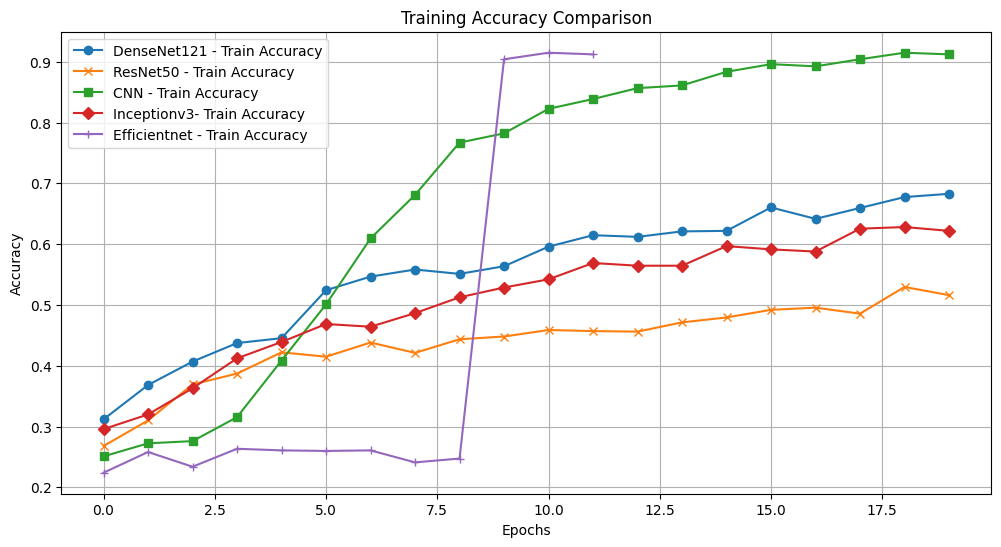

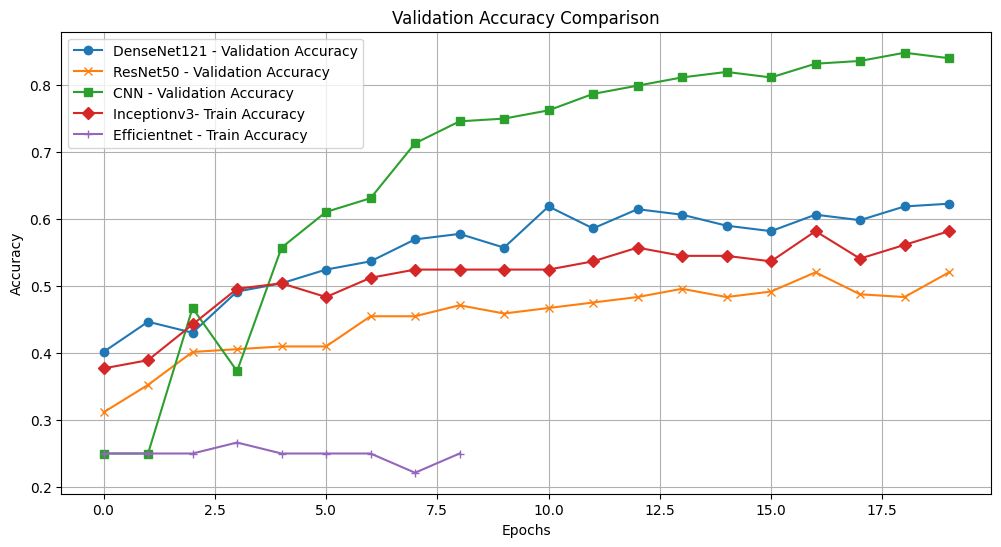

In [19]:
import matplotlib.pyplot as plt

# Actual accuracy values from the models
densenet_history = {
    "train_accuracy": [0.31182795763015747, 0.3682795763015747, 0.40681004524230957, 0.4372759759426117, 0.44534051418304443, 0.524193525314331, 0.5465949773788452, 0.5582437515258789, 0.551075279712677, 0.5636200904846191, 0.5958781242370605, 0.6146953701972961, 0.6120071411132812, 0.6209677457809448, 0.6218637824058533, 0.6603942513465881, 0.6415770649909973, 0.6594982147216797, 0.6774193644523621, 0.6827957034111023],  # Replace with DenseNet121 training accuracy from your output
    "val_accuracy": [0.40163934230804443, 0.44672131538391113, 0.4303278625011444, 0.49180328845977783, 0.5040983557701111, 0.5245901346206665, 0.5368852615356445, 0.5696721076965332, 0.5778688788414001, 0.5573770403862, 0.618852436542511, 0.5860655903816223, 0.6147540807723999, 0.6065573692321777, 0.5901639461517334, 0.5819672346115112, 0.6065573692321777, 0.5983606576919556, 0.618852436542511, 0.6229507923126221]     # Replace with DenseNet121 validation accuracy
}

resnet_history = {
    "train_accuracy": [0.2679211497306824, 0.3100358545780182, 0.36917561292648315, 0.3870967626571655, 0.4220430254936218, 0.4148745536804199, 0.43817204236984253, 0.421146959066391, 0.44354838132858276, 0.44802868366241455, 0.458781361579895, 0.45698925852775574, 0.4560931921005249, 0.47132617235183716, 0.4793906807899475, 0.49193549156188965, 0.4955197274684906, 0.4856630861759186, 0.5295698642730713, 0.5161290168762207],  # Replace with ResNet50 training accuracy from your output
    "val_accuracy": [0.31147539615631104, 0.35245901346206665, 0.40163934230804443, 0.4057376980781555, 0.4098360538482666, 0.4098360538482666, 0.4549180269241333, 0.4549180269241333, 0.4713114798069, 0.4590163826942444, 0.46721312403678894, 0.4754098355770111, 0.4836065471172333, 0.4959016442298889, 0.4836065471172333, 0.49180328845977783, 0.5204917788505554, 0.48770493268966675, 0.4836065471172333, 0.5204917788505554]     # Replace with ResNet50 validation accuracy
}

cnn_history = {
    "train_accuracy": [0.25089606642723083, 0.2724014222621918, 0.2759856581687927, 0.3154121935367584, 0.40860214829444885, 0.5008960366249084, 0.6093189716339111, 0.6810035705566406, 0.7670251131057739, 0.7822580933570862, 0.8225806355476379, 0.8387096524238586, 0.856630802154541, 0.8611111044883728, 0.883512556552887, 0.8960573673248291, 0.8924731016159058, 0.9041218757629395, 0.9148745536804199, 0.9121863842010498],  # Replace with CNN training accuracy from your output
    "val_accuracy": [0.25, 0.25, 0.46721312403678894, 0.37295082211494446, 0.5573770403862, 0.6106557250022888, 0.631147563457489, 0.7131147384643555, 0.7459016442298889, 0.75, 0.7622950673103333, 0.7868852615356445, 0.7991803288459778, 0.811475396156311, 0.8196721076965332, 0.811475396156311, 0.8319672346115112, 0.8360655903816223, 0.8483606576919556, 0.8401639461517334]     # Replace with CNN validation accuracy
}

inceptionv3_history = {
    "train_accuracy": [0.2956989109516144, 0.3198924660682678, 0.3629032373428345, 0.4121863842010498, 0.43906810879707336, 0.46863800287246704, 0.46415770053863525, 0.4865591526031494, 0.5125448107719421, 0.5286738276481628, 0.5421146750450134, 0.5689964294433594, 0.5645161271095276, 0.5645161271095276, 0.5967742204666138, 0.5913978219032288, 0.5878136157989502, 0.6254480481147766, 0.6281362175941467, 0.6218637824058533],  # Replace with CNN training accuracy from your output
    "val_accuracy": [ 0.37704917788505554, 0.3893442749977112, 0.44262295961380005, 0.4959016442298889, 0.5040983557701111, 0.4836065471172333, 0.5122950673103333, 0.5245901346206665, 0.5245901346206665, 0.5245901346206665, 0.5245901346206665, 0.5368852615356445, 0.5573770403862, 0.5450819730758667, 0.5450819730758667, 0.5368852615356445, 0.5819672346115112, 0.5409836173057556, 0.561475396156311, 0.5819672346115112]     # Replace with CNN validation accuracy
}

efficientnet_history = {
    "train_accuracy": [0.22401434183120728, 0.25806450843811035, 0.2338709682226181, 0.2634408473968506, 0.26075267791748047, 0.259856641292572, 0.26075267791748047, 0.2410394251346588, 0.247311830520629888, 0.9041218757629395, 0.9148745536804199, 0.9121863842010498],  # Replace with CNN training accuracy from your output
    "val_accuracy": [0.25, 0.25, 0.25, 0.2663934528827667, 0.25, 0.25, 0.25, 0.22131147980690002, 0.25]     # Replace with CNN validation accuracy
}

# Plot Training Accuracy
plt.figure(figsize=(12, 6))
plt.plot(densenet_history["train_accuracy"], label="DenseNet121 - Train Accuracy", marker='o')
plt.plot(resnet_history["train_accuracy"], label="ResNet50 - Train Accuracy", marker='x')
plt.plot(cnn_history["train_accuracy"], label="CNN - Train Accuracy", marker='s')
plt.plot(inceptionv3_history["train_accuracy"], label="Inceptionv3- Train Accuracy", marker='D')
plt.plot(efficientnet_history["train_accuracy"], label="Efficientnet - Train Accuracy", marker='+')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(densenet_history["val_accuracy"], label="DenseNet121 - Validation Accuracy", marker='o')
plt.plot(resnet_history["val_accuracy"], label="ResNet50 - Validation Accuracy", marker='x')
plt.plot(cnn_history["val_accuracy"], label="CNN - Validation Accuracy", marker='s')
plt.plot(inceptionv3_history["val_accuracy"], label="Inceptionv3- Train Accuracy", marker='D')
plt.plot(efficientnet_history["val_accuracy"], label="Efficientnet - Train Accuracy", marker='+')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
cnn_history = {
    "train_accuracy": [0.25089606642723083, 0.2724014222621918, 0.2759856581687927, 0.3154121935367584, 0.40860214829444885, 0.5008960366249084, 0.6093189716339111, 0.6810035705566406, 0.7670251131057739, 0.7822580933570862, 0.8225806355476379, 0.8387096524238586, 0.856630802154541, 0.8611111044883728, 0.883512556552887, 0.8960573673248291, 0.8924731016159058, 0.9041218757629395, 0.9148745536804199, 0.9121863842010498],  # Replace with CNN training accuracy from your output
    "val_accuracy": [0.25, 0.25, 0.46721312403678894, 0.37295082211494446, 0.5573770403862, 0.6106557250022888, 0.631147563457489, 0.7131147384643555, 0.7459016442298889, 0.75, 0.7622950673103333, 0.7868852615356445, 0.7991803288459778, 0.811475396156311, 0.8196721076965332, 0.811475396156311, 0.8319672346115112, 0.8360655903816223, 0.8483606576919556, 0.8401639461517334] ,    # Replace with CNN validation accuracy
    "train_loss"  :[1.5808738470077515, 1.3861569166183472, 1.3807867765426636, 1.3584747314453125, 1.2862768173217773, 1.1319200992584229, 0.9415658116340637, 0.7967393398284912, 0.6107652187347412, 0.5591495633125305, 0.4521285593509674, 0.40512600541114807, 0.36840471625328064, 0.3405810296535492, 0.2982032895088196, 0.25780758261680603, 0.26410984992980957, 0.21068589389324188, 0.1944546103477478, 0.2013626992702484],
    "val_loss": [1.3845394849777222, 1.380735158920288, 1.3712420463562012, 1.33280611038208, 1.2045369148254395, 1.0469897985458374, 0.8840964436531067, 0.7423387765884399, 0.6452341675758362, 0.606769323348999, 0.5642734169960022, 0.5551590323448181, 0.5415881872177124, 0.5282890796661377, 0.46057599782943726, 0.4893656373023987, 0.47062331438064575, 0.4315791726112366, 0.4571378529071808, 0.46160924434661865]
}

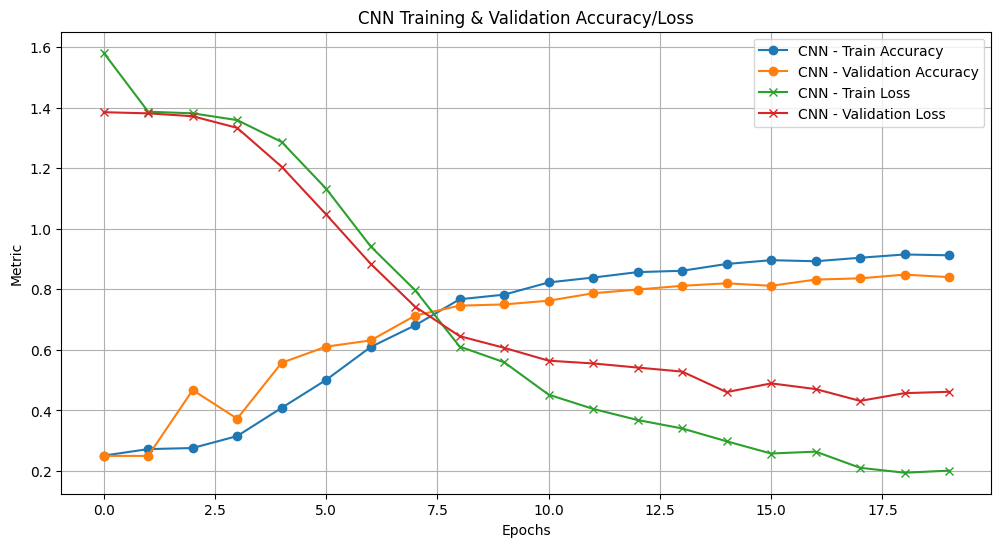

In [25]:

plt.figure(figsize=(12, 6))
epochs = range(len(cnn_history["train_accuracy"]))

plt.plot(epochs, cnn_history["train_accuracy"], label="CNN - Train Accuracy", marker='o')
plt.plot(epochs, cnn_history["val_accuracy"], label="CNN - Validation Accuracy", marker='o')
plt.plot(epochs, cnn_history["train_loss"], label="CNN - Train Loss", marker='x')
plt.plot(epochs, cnn_history["val_loss"], label="CNN - Validation Loss", marker='x')

plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.title("CNN Training & Validation Accuracy/Loss")
plt.legend()
plt.grid(True)
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step


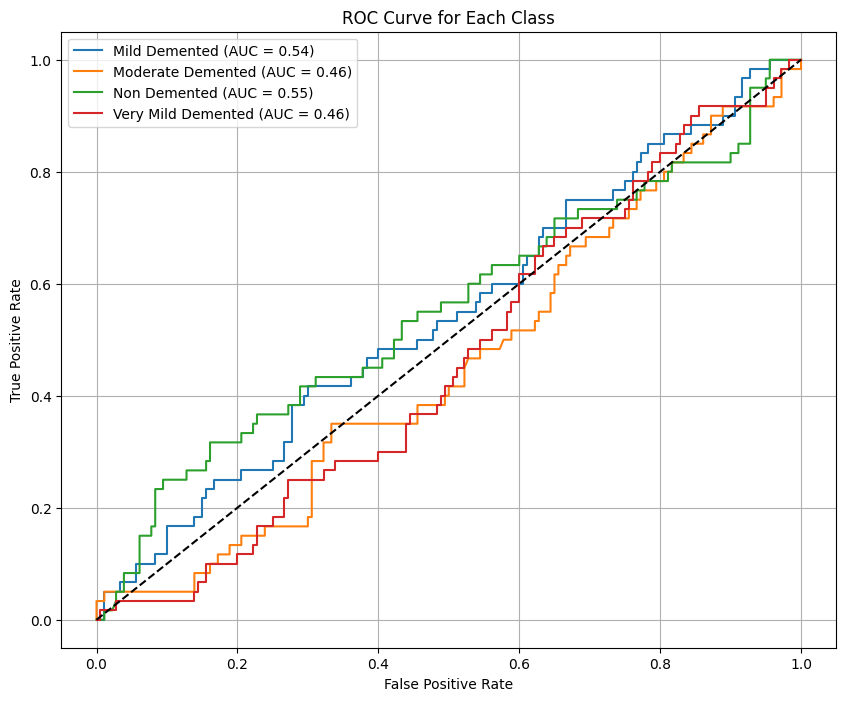

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))
y_pred_proba = model.predict(test_ds)  # Predicted probabilities

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#iterates over all layers in the model
for layer in model.layers:
    try:
        print(f"Layer Name: {layer.name}, Output Shape: {layer.output_shape}")
    except AttributeError:
        # Some layers, like InputLayer, might not have output_shape
        print(f"Layer Name: {layer.name} (no output shape)")

Layer Name: conv2d_100 (no output shape)
Layer Name: max_pooling2d_10 (no output shape)
Layer Name: conv2d_101 (no output shape)
Layer Name: max_pooling2d_11 (no output shape)
Layer Name: conv2d_102 (no output shape)
Layer Name: max_pooling2d_12 (no output shape)
Layer Name: flatten_4 (no output shape)
Layer Name: dense_18 (no output shape)
Layer Name: dropout_9 (no output shape)
Layer Name: dense_19 (no output shape)


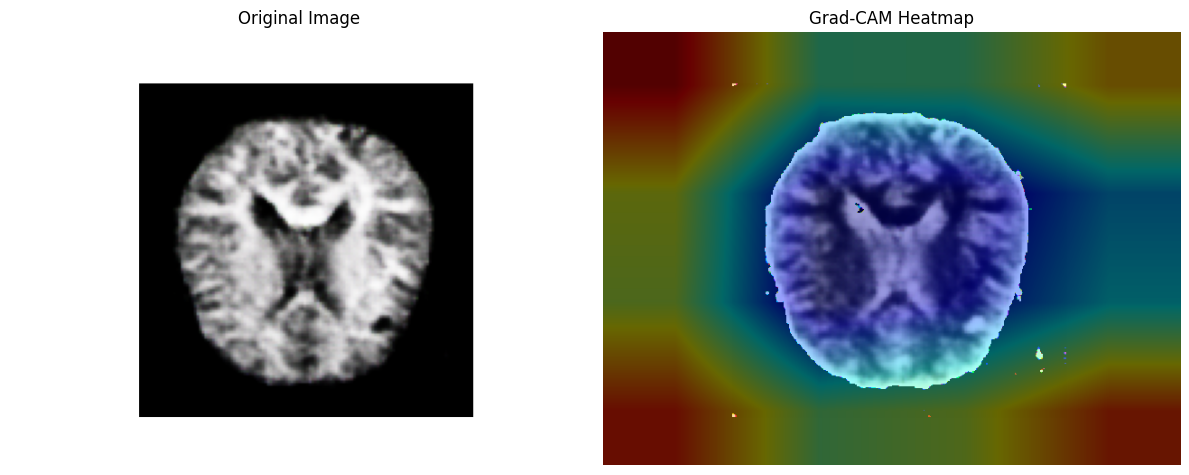

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define and Compile the DenseNet Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Grad-CAM Heatmap Generation
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for the given image.
    """
    # Create a model that maps inputs to the activations of the last conv layer and predictions
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with regard to the feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)

    # Pool the gradients over all axes except the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the gradients with the feature map outputs
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

#  Overlay Heatmap on Original Image
def overlay_heatmap_on_image(original_img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlays a heatmap on the original image.
    """
    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)

    # Combine heatmap with the original image
    overlayed_img = cv2.addWeighted(heatmap_colored, alpha, np.uint8(original_img * 255), 1 - alpha, 0)
    return overlayed_img

#  Load and Preprocess an Example Image
example_image_path = './GeneratedDataset4/VeryMildDemented/image_epoch_0092_img_7.png'
image = cv2.imread(example_image_path)
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting
image = cv2.resize(image, (128, 128))  # Resize to match model input
image = np.expand_dims(image, axis=0) / 255.0  # Normalize and add batch dimension

# Generate Grad-CAM Heatmap
last_conv_layer_name = "conv5_block16_concat"  # Last convolutional layer in DenseNet121
heatmap = get_gradcam_heatmap(model, image, last_conv_layer_name)

#  Overlay Heatmap on the Original Image
heatmap_overlay = overlay_heatmap_on_image(original_image, heatmap)

# Visualize the Results
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

# Display heatmap overlay
plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_overlay)
plt.axis("off")

plt.tight_layout()
plt.show()


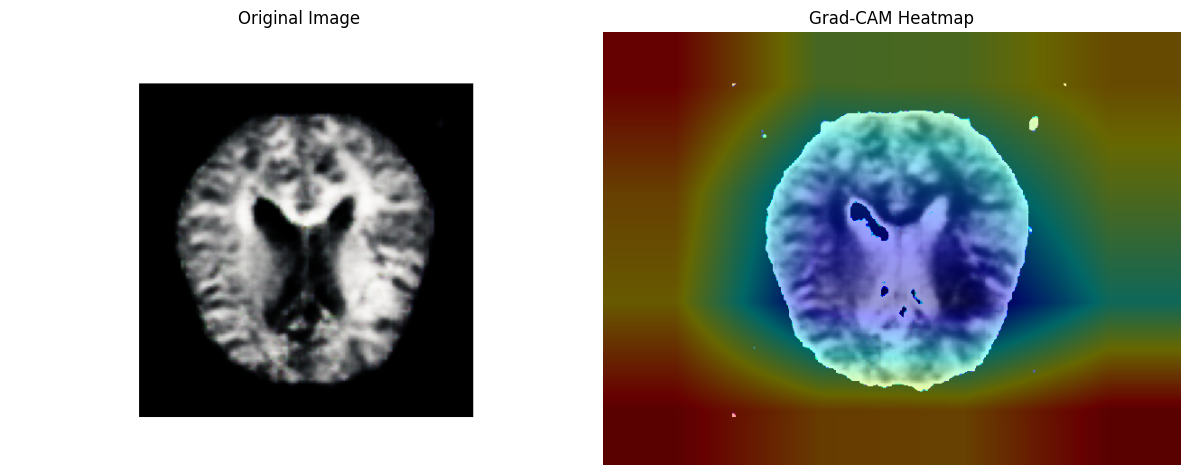

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define and Compile the DenseNet Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Grad-CAM Heatmap Generation
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for the given image.
    """
    # Create a model that maps inputs to the activations of the last conv layer and predictions
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with regard to the feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)

    # Pool the gradients over all axes except the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the gradients with the feature map outputs
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay Heatmap on Original Image
def overlay_heatmap_on_image(original_img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlays a heatmap on the original image.
    """
    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)

    # Combine heatmap with the original image
    overlayed_img = cv2.addWeighted(heatmap_colored, alpha, np.uint8(original_img * 255), 1 - alpha, 0)
    return overlayed_img

# Load and Preprocess an Example Image
example_image_path = './GeneratedDataset4/VeryMildDemented/image_epoch_0099_img_7.png'
image = cv2.imread(example_image_path)
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting
image = cv2.resize(image, (128, 128))  # Resize to match model input
image = np.expand_dims(image, axis=0) / 255.0  # Normalize and add batch dimension

# Generate Grad-CAM Heatmap
last_conv_layer_name = "conv5_block16_concat"  # Last convolutional layer in DenseNet121
heatmap = get_gradcam_heatmap(model, image, last_conv_layer_name)

# Overlay Heatmap on the Original Image
heatmap_overlay = overlay_heatmap_on_image(original_image, heatmap)

# Visualize the Results
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

# Display heatmap overlay
plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_overlay)
plt.axis("off")

plt.tight_layout()
plt.show()


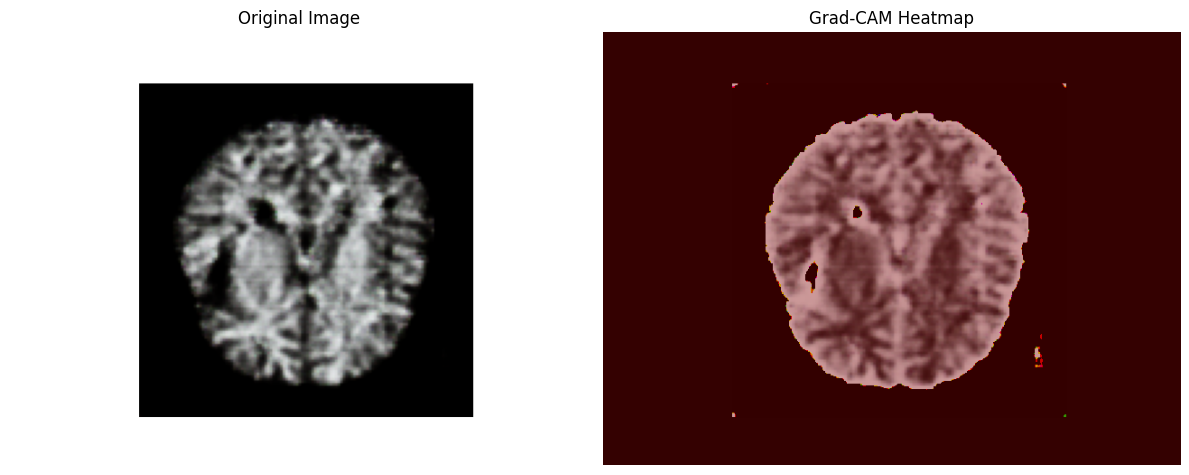

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define and Compile the DenseNet Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#  Grad-CAM Heatmap Generation
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for the given image.
    """
    # Create a model that maps inputs to the activations of the last conv layer and predictions
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with regard to the feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)

    # Pool the gradients over all axes except the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the gradients with the feature map outputs
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay Heatmap on Original Image
def overlay_heatmap_on_image(original_img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlays a heatmap on the original image.
    """
    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Apply a colormap to the heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)

    # Combine heatmap with the original image
    overlayed_img = cv2.addWeighted(heatmap_colored, alpha, np.uint8(original_img * 255), 1 - alpha, 0)
    return overlayed_img

# Load and Preprocess an Example Image
example_image_path = './GeneratedDataset4/NonDemented/image_epoch_0094_img_6.png'
image = cv2.imread(example_image_path)
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting
image = cv2.resize(image, (128, 128))  # Resize to match model input
image = np.expand_dims(image, axis=0) / 255.0  # Normalize and add batch dimension

# Generate Grad-CAM Heatmap
last_conv_layer_name = "conv5_block16_concat"  # Last convolutional layer in DenseNet121
heatmap = get_gradcam_heatmap(model, image, last_conv_layer_name)

# Overlay Heatmap on the Original Image
heatmap_overlay = overlay_heatmap_on_image(original_image, heatmap)

# Visualize the Results
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

# Display heatmap overlay
plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_overlay)
plt.axis("off")

plt.tight_layout()
plt.show()


In [1]:
import zipfile
import os

def zip_folder(folder_path, output_zip_file):
    """
    Zips the specified folder and saves it as a zip file.
    
    :param folder_path: Path to the folder to be zipped.
    :param output_zip_file: Path for the output zip file.
    """
    with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create the complete file path
                file_path = os.path.join(root, file)
                # Add file to the zip, maintaining folder structure
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Example usage
folder_to_zip = 'kkaur06'  # Replace with the folder you want to zip
output_zip = 'output_folder.zip' # Replace with the desired zip file name
zip_folder(folder_to_zip, output_zip)

print(f"Folder '{folder_to_zip}' has been zipped into '{output_zip}'")


Folder 'kkaur06' has been zipped into 'output_folder.zip'
